# Analysis of the cleaned Frasier Transcript Dataset

This takes a look how distinct the dialects of different each main character are

In [3]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("./data/cleanedTranscript.csv")
data.head(3)

,character,lines,season,episode,gender,title,directedBy,writtenBy,originalAirDate,viewershipInMillions,imdbVotes,imdbRatings,characterName,actorName,characterType,episodeCount
0,Frasier,listen to yourself bob you follow her to work ...,1,1,male,The Good Son,James Burrows,David Angell & Peter Casey & David Lee,1993-09-16,28.0,528,8.8,Frasier Crane,Kelsey Grammer,main,1.0
1,Roz,yes dr crane on line four we have russell from...,1,1,female,The Good Son,James Burrows,David Angell & Peter Casey & David Lee,1993-09-16,28.0,528,8.8,Roz Doyle,Peri Gilpin,main,1.0
2,Frasier,hello russell this is dr frasier crane im list...,1,1,male,The Good Son,James Burrows,David Angell & Peter Casey & David Lee,1993-09-16,28.0,528,8.8,Frasier Crane,Kelsey Grammer,main,1.0


## Word Frequency Analysis

In [4]:
def getNMostCommonWords(n: int) -> list[str]:
    """This gets the top n most common words from a file containing most common english words"""
    with open("./data/frasierWordCounts.txt") as file:
        commonWords =  file.read()

    # Get just the word from every pair
    commonWords = [pair.split()[0] for pair in commonWords.split("\n")[:-1]]
    return commonWords[:n]

In [5]:
def getWordCounts(data, character: str=None, wordWeights: dict[str, float]=None) -> dict[str, int]:
    """This function gets the word frequencies from the lines in a transcript dataset
    Params:
    data - A Pandas dataframe with transcript data
    character - Optional parameter specifying a character to get word frequencies for
    Returns: A dictionary of words and their frequency"""
    # If a character is specefied, filter the data by that character
    # Otherwise, just keep the data the same
    if character:
        filteredData = data[data["character"] == character]
    else:
        filteredData = data

    # Get the word counts for each line
    wordCounts = defaultdict(int)
    for line in filteredData["lines"]:
        for word in line.split():
            wordCounts[word] += 1

    # If there are words the user wants weighted 
    if wordWeights:
        for word, weight in wordWeights.items():
            wordCounts[word] *= weight
    
    return wordCounts

In [43]:
def wordFrequencyChart(data, character: str, **kwargs):
    """This function makes a plot showing the word frequency of a specific character"""
    #numWordsDisplay: int=None, topNWeightedWords=None, wordWeight=.1
    # Get kwargs
    numWordsDisplay = kwargs.get("numWordsDisplay") if kwargs.get("numWordsDisplay") else None
    topNWeightedWords = kwargs.get("topNWeightedWords") if kwargs.get("topNWeightedWords") else 0
    wordWeight = kwargs.get("wordWeight") if kwargs.get("wordWeight") else .1
    barColor = kwargs.get("barColor") if kwargs.get("barColor") else "purple"
    # Create plot
    fig, ax = plt.subplots(figsize=(10,6))
    fig.tight_layout(pad=7.5)
    fig.set_facecolor('White')

    # Get word weights
    wordWeights = {}
    for word in getNMostCommonWords(topNWeightedWords):
        wordWeights[word] = wordWeight
    
    # Get word counts for character
    characterCounts = list(getWordCounts(data, character, wordWeights).items())
    characterCounts.sort(key=lambda wordCount: wordCount[1], reverse=True)
    # If a max number of words is specified then select only those words
    if numWordsDisplay:
        characterCounts = characterCounts[:numWordsDisplay]

    # Get the words and frequencies on their own
    words = [x[0].title() for x in characterCounts]
    frequencies = [x[1] for x in characterCounts]

    # Create bars
    ax.bar(words, frequencies, color=barColor, edgecolor="black", linewidth=1.4)
    ax.set_xlabel("Word", fontsize=14)
    ax.set_ylabel("Word Count", fontsize=14)
    ax.set_title(f'{character.title()} Word Counts', fontsize = 16)
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.set_xticklabels(words, rotation=40)

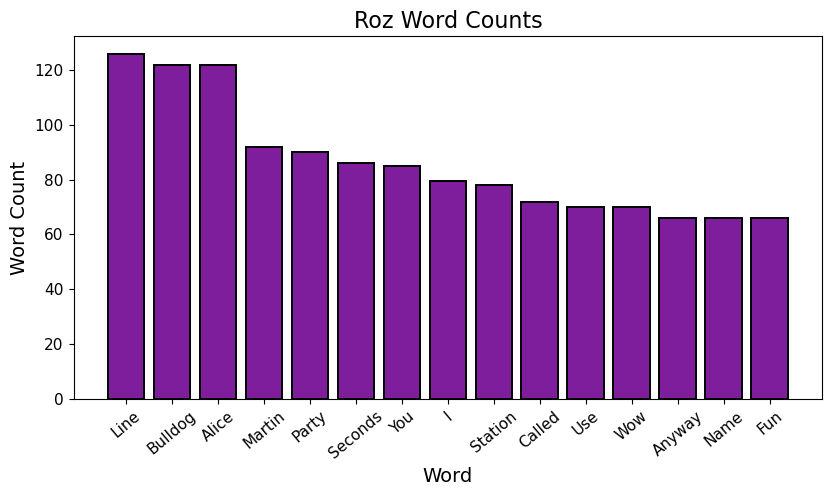

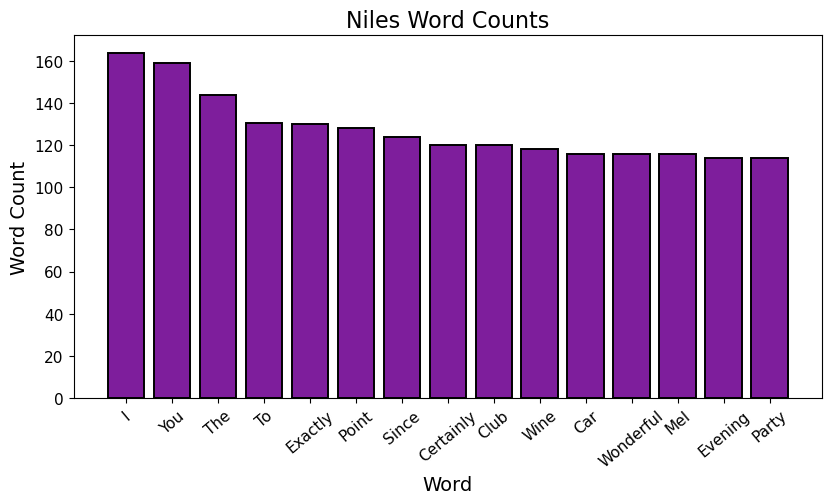

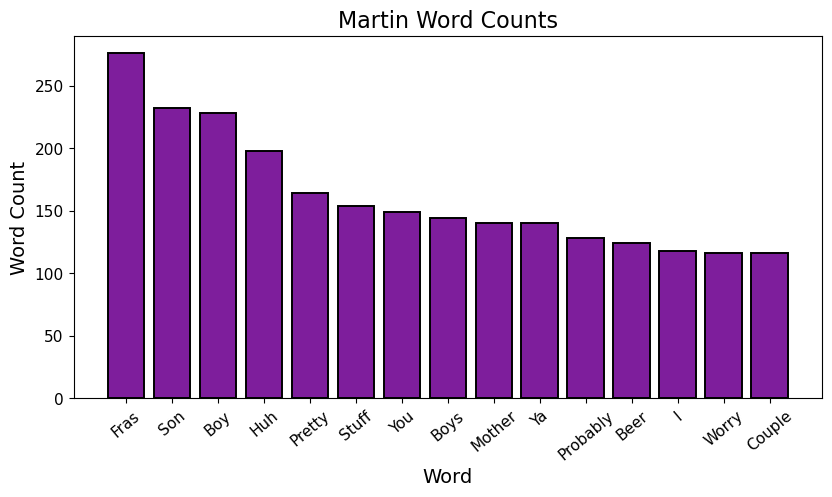

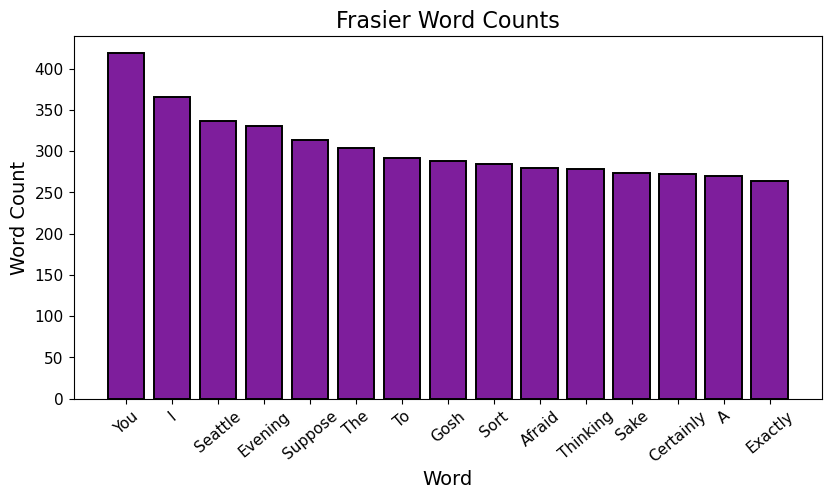

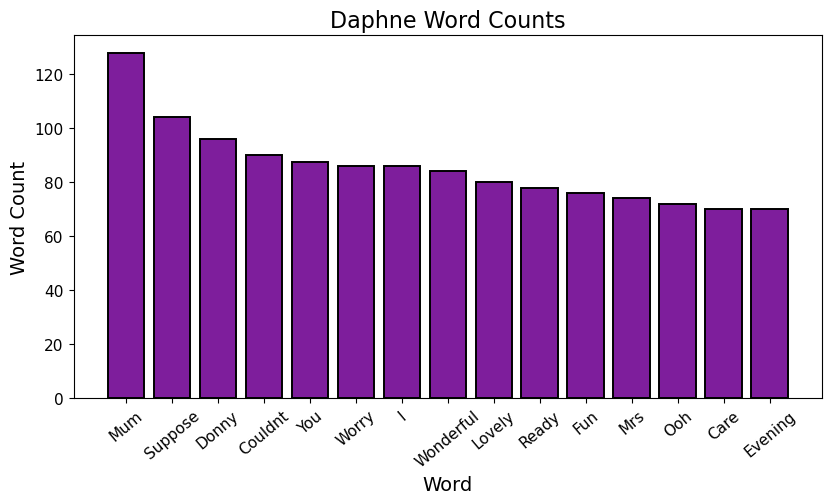

In [68]:
# Get unique main characters (Frasier, Niles, Roz, Martin, Daphne)
mainCharacters = duckdb.sql("""SELECT DISTINCT(character) FROM data
                            WHERE characterType = 'main'
                            ORDER BY character DESC""").to_df()

# Get word count charts for each character
for character in mainCharacters["character"]:
    wordFrequencyChart(data, character, numWordsDisplay=15, topNWeightedWords=300, wordWeight=.02, barColor="xkcd:purple")

In [5]:
def generateCharacterHeatmap(characterCounts: dict[str:dict[str:int]]):
    characters = ["Frasier", "Niles", "Martin", "Roz", "Daphne"]

    # Create 2d int character heatmap
    characterScores: list[list[int]] = []
    for i, character in enumerate(characters):
        characterScores.append([])
        for j, character2 in enumerate(characters):
            characterScores[-1].append(characterCounts[character][character2])

    # Create heatmap
    ax = sns.heatmap(characterScores, annot=True, cmap="crest", fmt='g', cbar_kws={'label': 'Number of Lines Predicted'})

    # Set y-axis label and x-axis label (which is really the title)
    ax.set_ylabel('Actual Character',size=14)
    ax.set_title('Predicted Character',size=14)

    # Change tick labels and move x-ticks to the top
    ax.xaxis.tick_top()
    ax.set_xticklabels(characters)
    ax.set_yticklabels(characters)

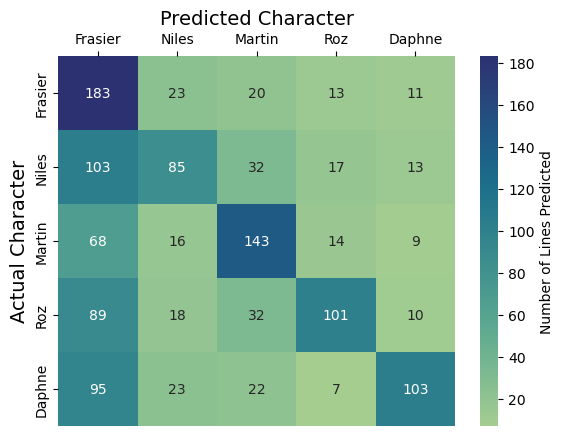

In [6]:
# 0 Word minimum
characterCounts = {'Frasier': {'Frasier': 183, 'Roz': 13, 'Niles': 23, 'Martin': 20, 'Daphne': 11}, 
                   'Roz': {'Frasier': 89, 'Roz': 101, 'Martin': 32, 'Daphne': 10, 'Niles': 18}, 
                   'Niles': {'Niles': 85, 'Frasier': 103, 'Roz': 17, 'Daphne': 13, 'Martin': 32}, 
                   'Martin': {'Martin': 143, 'Daphne': 9, 'Frasier': 68, 'Niles': 16, 'Roz': 14}, 
                   'Daphne': {'Niles': 23, 'Martin': 22, 'Daphne': 103, 'Frasier': 95, 'Roz': 7}}
generateCharacterHeatmap(characterCounts)

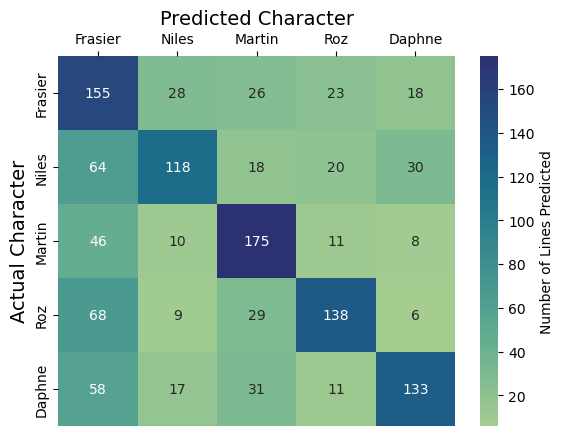

In [7]:
# 5 Word minimum
characterCounts = {'Frasier': {'Niles': 28, 'Frasier': 155, 'Martin': 26, 'Daphne': 18, 'Roz': 23}, 
                   'Roz': {'Niles': 9, 'Roz': 138, 'Frasier': 68, 'Daphne': 6, 'Martin': 29}, 
                   'Niles': {'Niles': 118, 'Daphne': 30, 'Frasier': 64, 'Martin': 18, 'Roz': 20}, 
                   'Martin': {'Martin': 175, 'Frasier': 46, 'Daphne': 8, 'Niles': 10, 'Roz': 11}, 
                   'Daphne': {'Frasier': 58, 'Martin': 31, 'Daphne': 133, 'Roz': 11, 'Niles': 17}}
generateCharacterHeatmap(characterCounts)

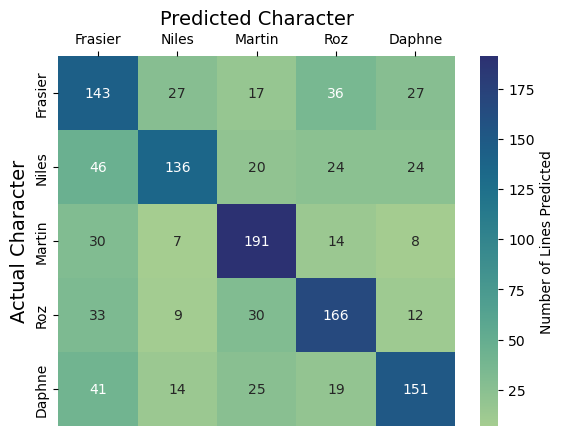

In [8]:
# 10 Word minimum
characterCounts = {'Frasier': {'Frasier': 143, 'Daphne': 27, 'Roz': 36, 'Niles': 27, 'Martin': 17}, 
                   'Roz': {'Roz': 166, 'Martin': 30, 'Daphne': 12, 'Frasier': 33, 'Niles': 9}, 
                   'Niles': {'Roz': 24, 'Daphne': 24, 'Niles': 136, 'Martin': 20, 'Frasier': 46}, 
                   'Martin': {'Martin': 191, 'Frasier': 30, 'Niles': 7, 'Roz': 14, 'Daphne': 8}, 
                   'Daphne': {'Daphne': 151, 'Martin': 25, 'Niles': 14, 'Frasier': 41, 'Roz': 19}}
generateCharacterHeatmap(characterCounts)

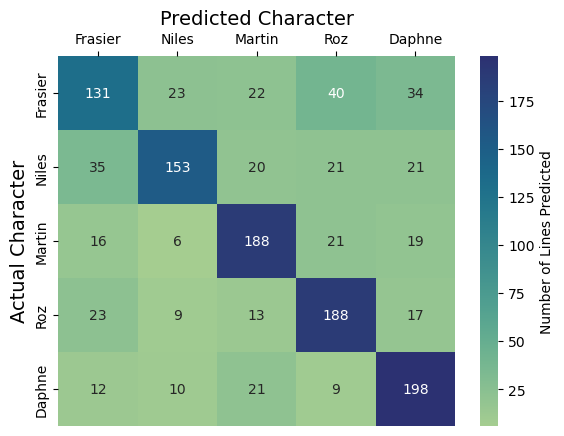

In [9]:
# 15 Word minimum
characterCounts = {'Frasier': {'Roz': 40, 'Frasier': 131, 'Niles': 23, 'Daphne': 34, 'Martin': 22}, 
                   'Roz': {'Roz': 188, 'Frasier': 23, 'Daphne': 17, 'Martin': 13, 'Niles': 9}, 
                   'Niles': {'Frasier': 35, 'Niles': 153, 'Daphne': 21, 'Roz': 21, 'Martin': 20}, 
                   'Martin': {'Martin': 188, 'Roz': 21, 'Daphne': 19, 'Niles': 6, 'Frasier': 16}, 
                   'Daphne': {'Daphne': 198, 'Martin': 21, 'Frasier': 12, 'Roz': 9, 'Niles': 10}}
generateCharacterHeatmap(characterCounts)

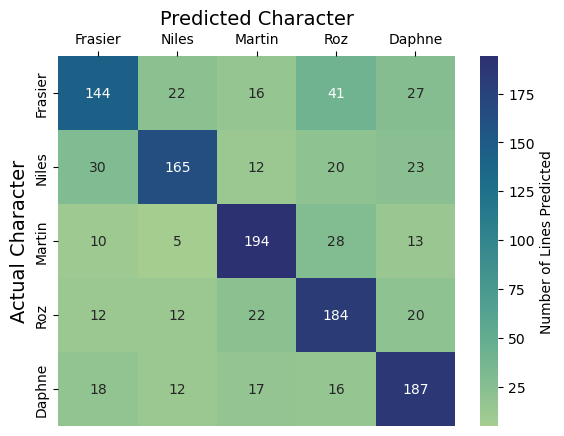

In [10]:
# 20 Word minimum
characterCounts = {'Frasier': {'Frasier': 144, 'Niles': 22, 'Daphne': 27, 'Martin': 16, 'Roz': 41}, 
                   'Roz': {'Niles': 12, 'Roz': 184, 'Martin': 22, 'Daphne': 20, 'Frasier': 12}, 
                   'Niles': {'Niles': 165, 'Martin': 12, 'Roz': 20, 'Frasier': 30, 'Daphne': 23}, 
                   'Martin': {'Martin': 194, 'Roz': 28, 'Daphne': 13, 'Niles': 5, 'Frasier': 10}, 
                   'Daphne': {'Daphne': 187, 'Frasier': 18, 'Roz': 16, 'Niles': 12, 'Martin': 17}}
generateCharacterHeatmap(characterCounts)

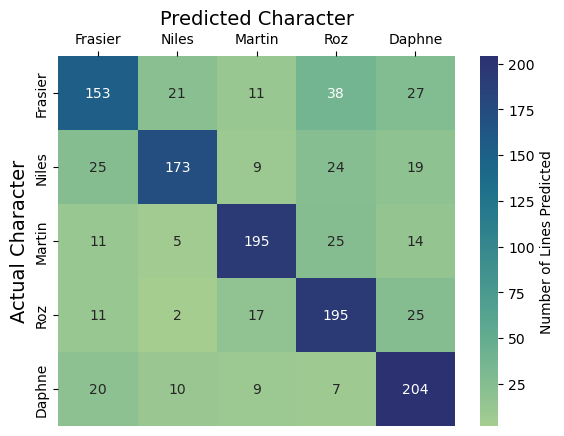

In [11]:
# 25 Word minimum
characterCounts = {'Frasier': {'Niles': 21, 'Frasier': 153, 'Daphne': 27, 'Roz': 38, 'Martin': 11}, 
                   'Roz': {'Roz': 195, 'Daphne': 25, 'Frasier': 11, 'Martin': 17, 'Niles': 2}, 
                   'Niles': {'Niles': 173, 'Daphne': 19, 'Frasier': 25, 'Roz': 24, 'Martin': 9}, 
                   'Martin': {'Martin': 195, 'Roz': 25, 'Daphne': 14, 'Niles': 5, 'Frasier': 11}, 
                   'Daphne': {'Daphne': 204, 'Niles': 10, 'Frasier': 20, 'Martin': 9, 'Roz': 7}}
generateCharacterHeatmap(characterCounts)